<a name='0'></a>
# Random Forests - Intro and Regression

---

## 🌲 Random Forests - Intro

* Random Forests are **powerful supervised ML algorithms** used for both **classification** and **regression**.

* They work by **combining multiple random decision trees** and **averaging their predictions**.

* Since single decision trees often **overfit**, combining many of them helps **reduce overfitting**.

* Random Forests are a type of **ensemble model**.

* Unlike many algorithms, Random Forests can **show how important each feature** is for predictions — this is built into Scikit-learn.

---


### Contents

* [1 - Imports](#1)
* [2 - Loading the data](#2)
* [3 - Exploratory Analysis](#3)
* [4 - Preprocessing the data](#4)
* [5 - Training Random Forests Regressor](#5)
* [6 - Evaluating Random Forests Regressor](#6)
* [7 - Improving Random Forests Regressor](#7)
* [8 - Feature Importance](#8)
* [9 - Evaluating the Improved Model on the Test set](#9)


<a name='1'></a>
## 1 - Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<a name='2'></a>

## 2 - Loading the data

In this regression task with random forests, I'll use Machine CPU (Central Processing Unit) data which is available at [OpenML](https://www.openml.org/t/5492). I'll load it with Sklearn `fetch_openml` function.

In this notebook, I'll predict the relative performance of the CPU given the following data:

* MYCT: machine cycle time in nanoseconds (integer)
* MMIN: minimum main memory in kilobytes (integer)
* MMAX: maximum main memory in kilobytes (integer)
* CACH: cache memory in kilobytes (integer)
* CHMIN: minimum channels in units (integer)
* CHMAX: maximum channels in units (integer)
* PRP: published relative performance (integer) (target variable)

In [2]:
from sklearn.datasets import fetch_openml

machine_cpu = fetch_openml(name='machine_cpu', version=1)

In [3]:
type(machine_cpu)

sklearn.utils._bunch.Bunch

In [4]:
machine_cpu.data.shape

(209, 6)

In [5]:
# displaying feature names
machine_cpu.feature_names

['MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX']

In [6]:
# getting the whole dataframe
machine_data = machine_cpu.frame

In [7]:
type(machine_data)

pandas.core.frame.DataFrame

<a name='3'></a>
## 3 - Exploratory Analysis

In [8]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(machine_data, test_size=0.2, random_state=20)

print('The size of training data is: {} \nThe size of testing data is: {}'.format(len(train_data), len(test_data)))

The size of training data is: 167 
The size of testing data is: 42


array([[<Axes: title={'center': 'MYCT'}>,
        <Axes: title={'center': 'MMIN'}>,
        <Axes: title={'center': 'MMAX'}>],
       [<Axes: title={'center': 'CACH'}>,
        <Axes: title={'center': 'CHMIN'}>,
        <Axes: title={'center': 'CHMAX'}>],
       [<Axes: title={'center': 'class'}>, <Axes: >, <Axes: >]],
      dtype=object)

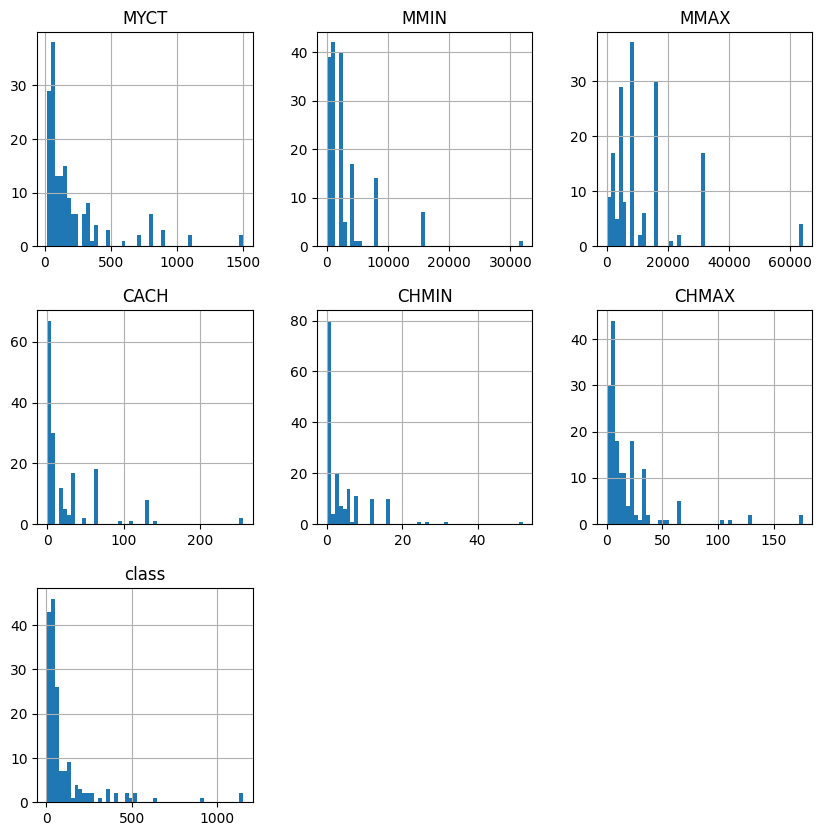

In [9]:
# histogram
train_data.hist(bins=50, figsize=(10, 10))

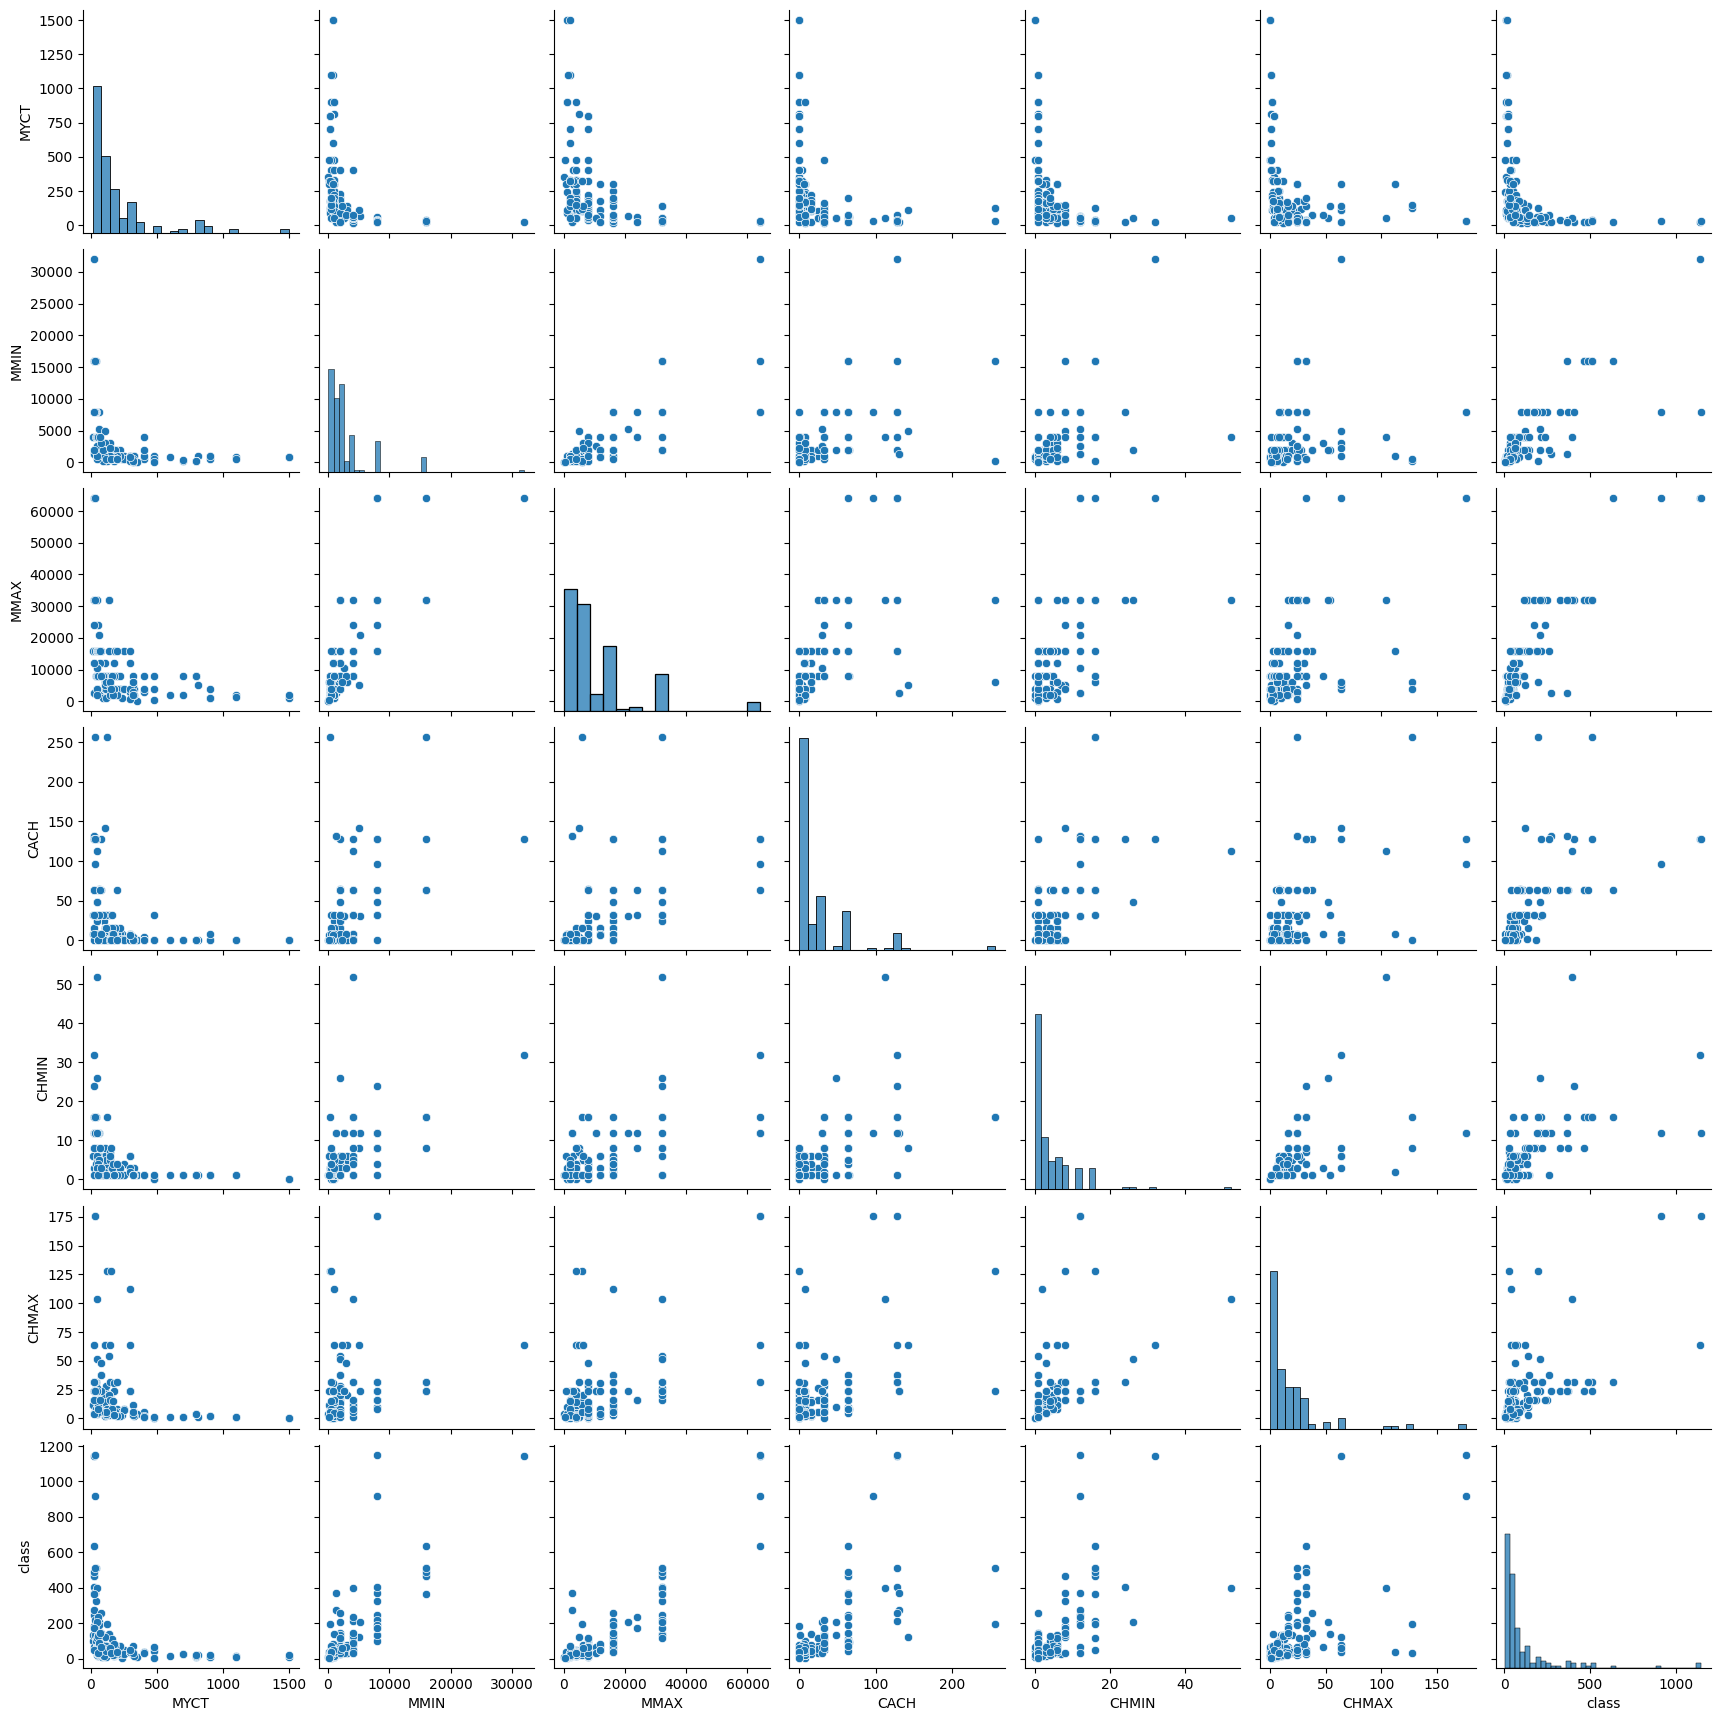

In [10]:
# pairplot
sns.pairplot(train_data)

In [11]:
# summary statistics
train_data.describe()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,class
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,207.958084,2900.826347,11761.161677,26.071856,4.760479,18.616766,109.185629
std,266.772823,4165.950964,12108.332354,42.410014,6.487439,27.489919,174.061117
min,17.000000,64.000000,64.000000,0.000000,0.000000,0.000000,6.000000
25%,50.000000,768.000000,4000.000000,0.000000,1.000000,5.000000,27.500000
50%,110.000000,2000.000000,8000.000000,8.000000,2.000000,8.000000,50.000000
75%,232.500000,3100.000000,16000.000000,32.000000,6.000000,24.000000,110.000000
max,1500.000000,32000.000000,64000.000000,256.000000,52.000000,176.000000,1150.000000


In [12]:
# checking missing values
train_data.isnull().sum()

,0
MYCT,0
MMIN,0
MMAX,0
CACH,0
CHMIN,0
CHMAX,0
class,0


In [13]:
# checking feature correlation
corr = train_data.corr()
corr['class']

,class
MYCT,-0.301805
MMIN,0.797751
MMAX,0.869077
CACH,0.671581
CHMIN,0.648653
CHMAX,0.606557
class,1.000000


<Axes: >

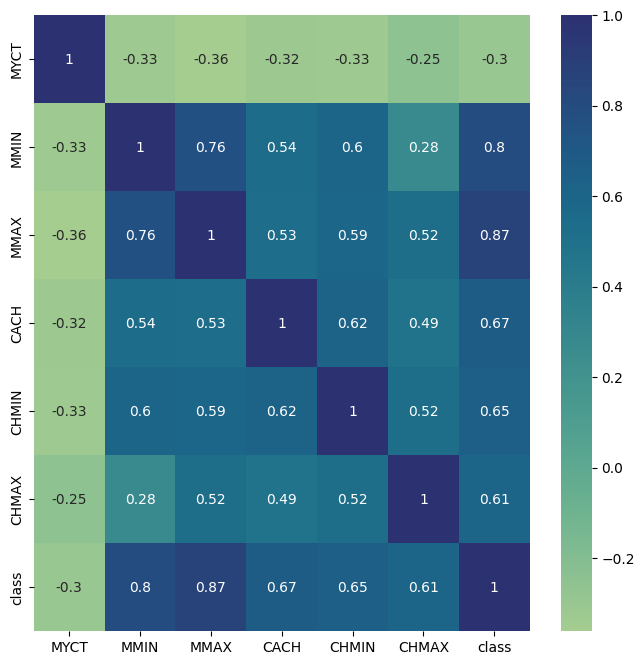

In [14]:
# visualizing correlation
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True, cmap='crest')

<a name='4'></a>

## 4 - Data Preprocessing

I'm gonna set up a pipeline to scale features but before that, taking training input data and labels.

In [15]:
X_train = train_data.drop('class', axis=1)
y_train = train_data[['class']]

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler', StandardScaler())
])

X_train_scaled = pipe.fit_transform(X_train)

<a name='5'></a>

## 5 - Training Random Forests Regressor

In [17]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(min_samples_split=2,bootstrap=False, random_state=42,n_jobs=-1)

forest_reg.fit(X_train_scaled, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(bootstrap=False, n_jobs=-1, random_state=42)

<a name='6'></a>

## 6 - Evaluating Random Forests Regressor
---

### 🔹 Checking Training Error

* First, checking **Root Mean Squared Error (RMSE)** on the **training data**.
* Not using test data yet — model not improved.
* Making a small **function** to calculate RMSE easily and avoid repeating code.

---

In [18]:
from sklearn.metrics import mean_squared_error

def predict(input_data,model,labels):

    preds = model.predict(input_data)
    mse = mean_squared_error(labels,preds)
    rmse = np.sqrt(mse)
    rmse

    return rmse

In [19]:
predict(X_train_scaled, forest_reg, y_train)

np.float64(9.724590719956222)

<a name='7'></a>

## 7 - Improving Random Forests

### 🧩 Cell 1 — Checking current parameters

In [20]:
# Checking all parameters of the Random Forest model
forest_reg.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### 🧩 Cell 2 — Setting up parameter grid

In [21]:
# Defining the hyperparameters to test in Grid Search
from sklearn.model_selection import GridSearchCV

params_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_leaf_nodes': list(range(1, 50))
}

### 🧩 Cell 3 — Run Grid Search

In [22]:
# Running GridSearchCV to find the best combination of hyperparameters
grid_search = GridSearchCV(
    RandomForestRegressor(min_samples_split=2, bootstrap=False, random_state=42),
    params_grid,
    verbose=1,
    cv=5
)

grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 245 candidates, totalling 1225 fits


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(bootstrap=False, random_state=42),
             param_grid={'max_leaf_nodes': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...],
                         'n_estimators': [100, 200, 300, 400, 500]},
             verbose=1)

### 🧩 Cell 4 — Checking best results

In [23]:
# Displaying best parameters and best model
grid_search.best_params_
forest_best = grid_search.best_estimator_

### 🧩 Cell 5 — Evaluating model

In [25]:
# Checking RMSE on training data
predict(X_train_scaled, forest_best, y_train)

np.float64(12.217411163164076)

### 🧩 Cell 6 — Note

In [26]:
# Even after tuning, the model didn’t improve much.
# One reason could be bootstrap=False.
# I can try changing it to True and see how the prediction changes.
# Random Forest performance often depends on proper parameter balance.

<a name='8'></a>
## 8. Feature Importance

---

### 🧠 **Feature Importance in Random Forests**

* Random Forests can show **how much each feature contributes** to the model’s performance.
* The importance values range between **0 and 1**.
* A value **closer to 1** means the feature is **more important** for the model.

---


In [27]:
# Getting feature importance scores from the trained Random Forest model
feat_import = forest_best.feature_importances_

# Creating a dictionary with feature names and their importance values
feat_dict = {
    'Features': X_train.columns,
    'Feature Importance': feat_import
}

# Converting dictionary to DataFrame for better visualization
pd.DataFrame(feat_dict)

,Features,Feature Importance
0,MYCT,0.002990
1,MMIN,0.005777
2,MMAX,0.835472
3,CACH,0.117459
4,CHMIN,0.007567
5,CHMAX,0.030735


---

### 💡 **Understanding Feature Importance Results**

* The top 2 important features are **MMAX** (Maximum Main Memory) and **CACH** (Cache Memory).
* This makes sense — both memory size and cache directly affect CPU speed and performance.
* More **RAM** and **cache** mean faster data access and quicker processing.
* So, the model correctly identified the key factors that influence CPU performance.

---


<a name='9'></a>
## 9. Evaluating the Model on the Test Set

I'm gonna evaluate the model on the test set.

But I will first run the pipeline on the test data. Note that I only did transform (not fit_transform).

In [29]:
X_test = test_data.drop('class', axis=1)
y_test = test_data['class']

test_scaled = pipe.transform(X_test)

In [30]:
predict(test_scaled, forest_best, y_test)

np.float64(41.258341325352305)

---

**Test set results are poor → sign of overfitting**

* Model performs well on training data but poorly on unseen data.
* Ways to improve:

  1. Regularize by tuning more hyperparameters.
  2. Increase dataset size and improve data quality (often most effective).

**Summary:**

* Learned fundamentals of Random Forests.
* Applied them to predict CPU performance.
---